# Hilbert-Huang Transform (HHT) 解析チュートリアル

このチュートリアルでは、**gwexpy** を使用した **Hilbert-Huang Transform (HHT)** 解析の手順を解説します。
HHT は、非線形・非定常な信号の解析に適しており、従来のフーリエ変換やウェーブレット変換では捉えきれない局所的な周波数変動（瞬時周波数）を抽出するのに強力な手法です。

HHT は以下の2つの主要なステップから成ります：
1.  **Empirical Mode Decomposition (EMD)**: 信号を固有モード関数 (IMF: Intrinsic Mode Function) に分解します。
2.  **Hilbert Spectral Analysis**: 各 IMF に対してヒルベルト変換を行い、瞬時振幅と瞬時周波数を計算します。

**注意**: この機能を使用するには `PyEMD` (EMD-signal) パッケージがインストールされている必要があります。
```bash
pip install EMD-signal
```

In [13]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeries

# PyEMDの確認
try:
    import PyEMD

    print("PyEMD is installed and ready.")
except ImportError:
    raise ImportError(
        "このチュートリアルには 'PyEMD' (EMD-signal) が必要です。 pip install EMD-signal を実行してください。"
    )

PyEMD is installed and ready.


## 1. 理論的背景とHHTの利点

### HHT (Hilbert-Huang Transform) とは
HHTは、非線形・非定常な信号データを解析するための強力な手法です。
以下の2つの主要なプロセスから構成されます：

1.  **EMD (Empirical Mode Decomposition)**: 元の信号を、異なる周波数スケールを持つ固有モード関数 (IMF: Intrinsic Mode Function) の和に分解します。
2.  **HSA (Hilbert Spectral Analysis)**: 各IMFに対してヒルベルト変換を適用し、**瞬時周波数 (Instantaneous Frequency)** と瞬時振幅を計算します。

### 従来のSTFTとの違い
短時間フーリエ変換 (STFT) やウェーブレット変換では、時間分解能と周波数分解能の間にトレードオフ（不確定性原理による制限）が存在します。
一方、HHTは局所的な時間スケールに基づいて適応的に基底を生成するため、この制限を受けず、**高い時間・周波数分解能**を同時に達成可能です。

### EEMD (Ensemble EMD)
通常のEMDでは、断続的な信号やノイズによって、一つのIMFの中に異なる周波数成分が混じる「モード混合 (Mode Mixing)」が発生することがあります。
これを解決するために、**EEMD (Ensemble EMD)** が提案されています。
-   元の信号にホワイトノイズを加えたものを多数生成（アンサンブル）。
-   それぞれの信号に対してEMDを実行。
-   得られたIMFのアンサンブル平均をとることで、ノイズをキャンセルし、物理的に意味のあるモードを安定して抽出します。


## 2. シミュレーション：SASIモードの再現

超新星爆発（CCSN）の重力波解析において、**SASI (Standing Accretion Shock Instability)** と呼ばれる不安定性は重要な観測対象です。
ここでは、SASI由来の重力波を模擬した **Sine-Gaussian** 信号を作成し、解析してみましょう（参考: Takeda et al. 2021）。

Sine-Gaussian信号は以下の式で表されます：
$$ h(t) = A \exp\left( - \left( \frac{2\pi (t - t_0)}{t_{\text{width}}} \right)^2 \right) \sin(2\pi f_0 t) $$


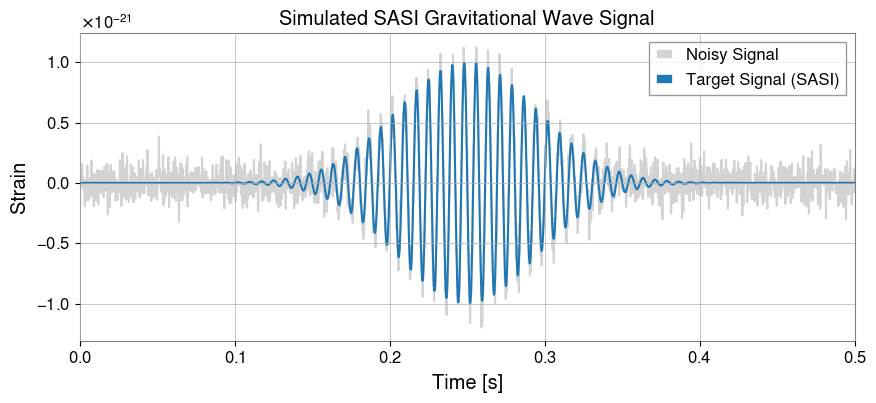

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from scipy.signal import hilbert
import PyEMD


def sine_gaussian(t, t0, t_width, f0, amp=1.0):
    exponent = -(((2 * np.pi * (t - t0)) / t_width) ** 2)
    return amp * np.exp(exponent) * np.sin(2 * np.pi * f0 * t)


# パラメータ設定 (SASIモードを模倣)
duration = 0.5  # seconds
fs = 4096  # sampling rate
t = np.linspace(0, duration, int(duration * fs))

# 信号生成
t0 = 0.25  # peak time
t_width = 0.4  # width
f0 = 130.0  # frequency (Hz)
clean_signal = sine_gaussian(t, t0, t_width, f0, amp=1e-21)

# ノイズの追加
np.random.seed(42)
noise_amp = 0.1e-21
noise = np.random.normal(0, noise_amp, len(t))
data = clean_signal + noise

# TimeSeries オブジェクトの作成
ts_data = TimeSeries(
    data, t0=0, sample_rate=fs, name="Simulated SASI Signal", unit="strain"
)

# プロット
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, ts_data.value, label="Noisy Signal", color="lightgray")
ax.plot(t, clean_signal, label="Target Signal (SASI)", color="tab:blue")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain")
ax.set_xlim(0, duration)
ax.legend()
plt.title("Simulated SASI Gravitational Wave Signal")
plt.show()

## 3. 比較解析：STFT vs HHT

同じ信号に対して、STFT（スペクトログラム）と HHT（ヒルベルトスペクトル）を適用し、その分解能の違いを比較します。


**注意**: 以下の結果では、STFTの方がノイズに対して堅牢で、信号が綺麗に見えるかもしれません。
これは、標準的なEMDがノイズの影響を受けやすく「モード混合」を起こすためです。
この問題は、次節で紹介する **EEMD** を用いることで劇的に改善されますが、まずは基本的なHHTの挙動を確認しましょう。

Extracted 9 IMFs from normalized data.


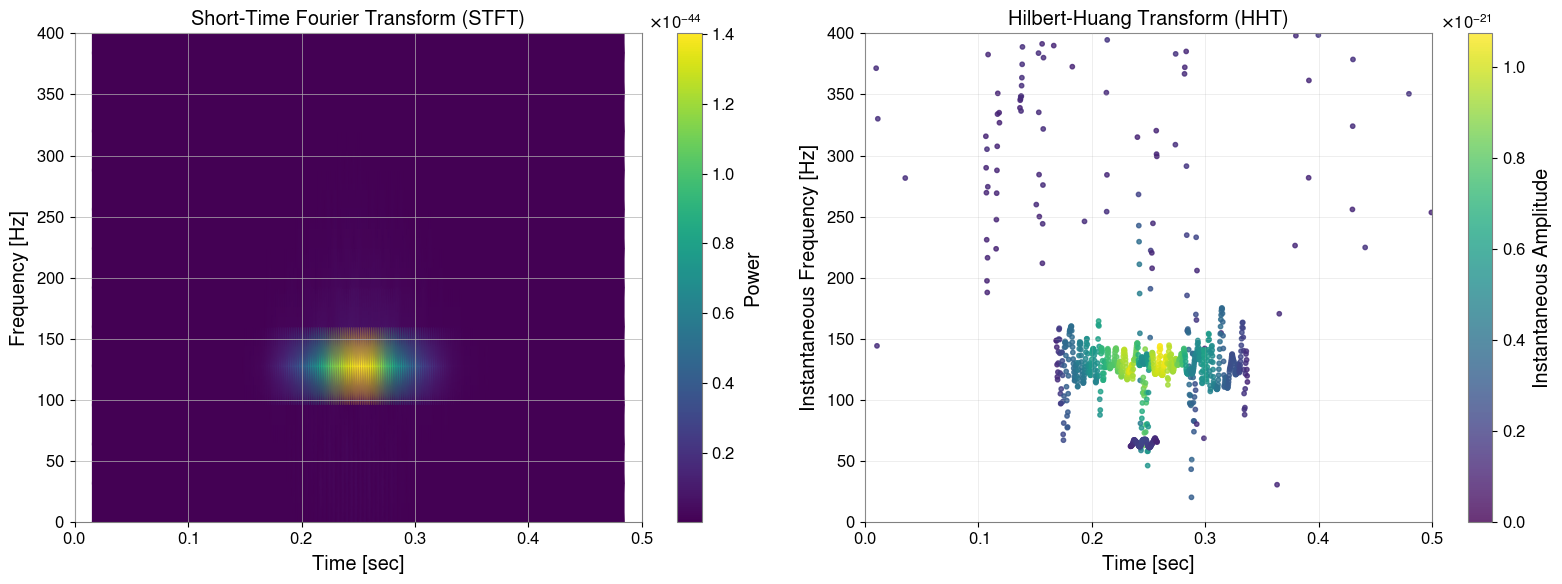

In [15]:
# --- 1. STFT (Spectrogram) using gwexpy API ---
# Convert sample counts to time-based parameters for gwexpy API:
# nperseg=128 samples → fftlength = 128/fs seconds
# noverlap=120 samples → overlap = 120/fs seconds
spec = ts_data.spectrogram(fftlength=128/fs, overlap=120/fs)
f_stft = spec.frequencies.value
t_stft = spec.times.value
Sxx = spec.value

# --- 2. HHT (EMD + Hilbert) ---
# 重要: EMDは数値的な許容誤差（Tolerance）を持つため、重力波のような極小振幅(1e-21)では
# うまく分解できないことがあります。そのため、一度正規化して計算し、後でスケールを戻します。
data_std = np.std(ts_data.value)
data_norm = ts_data.value / data_std

emd = PyEMD.EMD()
imfs_norm = emd.emd(data_norm)
imfs = imfs_norm * data_std  # スケールを戻す
n_imfs = imfs.shape[0]

print(f"Extracted {n_imfs} IMFs from normalized data.")

# ヒルベルト変換
instant_freqs = []
instant_amps = []

for imf in imfs:
    analytic_signal = hilbert(imf)
    inst_amp = np.abs(analytic_signal)
    inst_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = np.diff(inst_phase) / (2.0 * np.pi) * fs
    inst_freq = np.insert(inst_freq, 0, inst_freq[0])

    instant_freqs.append(inst_freq)
    instant_amps.append(inst_amp)

# --- プロット ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# STFT
mesh = ax1.pcolormesh(t_stft, f_stft, Sxx, shading="gouraud", cmap="viridis")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_xlabel("Time [sec]")
ax1.set_title("Short-Time Fourier Transform (STFT)")
ax1.set_ylim(0, 400)
ax1.set_xlim(0, duration)
plt.colorbar(mesh, ax=ax1, label="Power")

# HHT Plot
# 視認性のため、振幅が小さい点（ノイズ）をフィルタリング
max_amp = np.max([np.max(a) for a in instant_amps])
threshold = max_amp * 0.1  # 最大振幅の10%以上を表示

for i in range(n_imfs):
    mask = instant_amps[i] > threshold
    if np.any(mask):
        sc = ax2.scatter(
            t[mask],
            instant_freqs[i][mask],
            c=instant_amps[i][mask],
            cmap="viridis",
            s=10,
            alpha=0.8,
            vmin=0,
            vmax=max_amp,
        )

ax2.set_ylabel("Instantaneous Frequency [Hz]")
ax2.set_xlabel("Time [sec]")
ax2.set_title("Hilbert-Huang Transform (HHT)")
ax2.set_ylim(0, 400)
ax2.set_xlim(0, duration)
ax2.grid(alpha=0.3)

try:
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label("Instantaneous Amplitude")
except Exception:
    pass

plt.tight_layout()
plt.show()

## 4. 応用：EEMDによるモード抽出とパラメータ推定

### EEMDの適用
上記の単純なEMDの結果では、ノイズの影響で周波数が振動したり、本来の130Hzの信号が複数のIMFに分割されてしまう（モード混合）ことがあります。
**EEMD (Ensemble EMD)** を使用することで、これを改善できます。

> **Sasaoka et al. (2024)** では、CCSNからの重力波解析において、EEMD（またはCEEMD）を用いることで、原始中性子星（PNS）の振動モードを正確に抽出し、その周波数進化から PNS の物理量（質量や半径の比 $M/R^2$）を推定できることが示されています。

以下のコードは、PyEMDを使用してEEMDを実行する例です。


Running EEMD on normalized data...
EEMD completed. Extracted 9 IMFs.


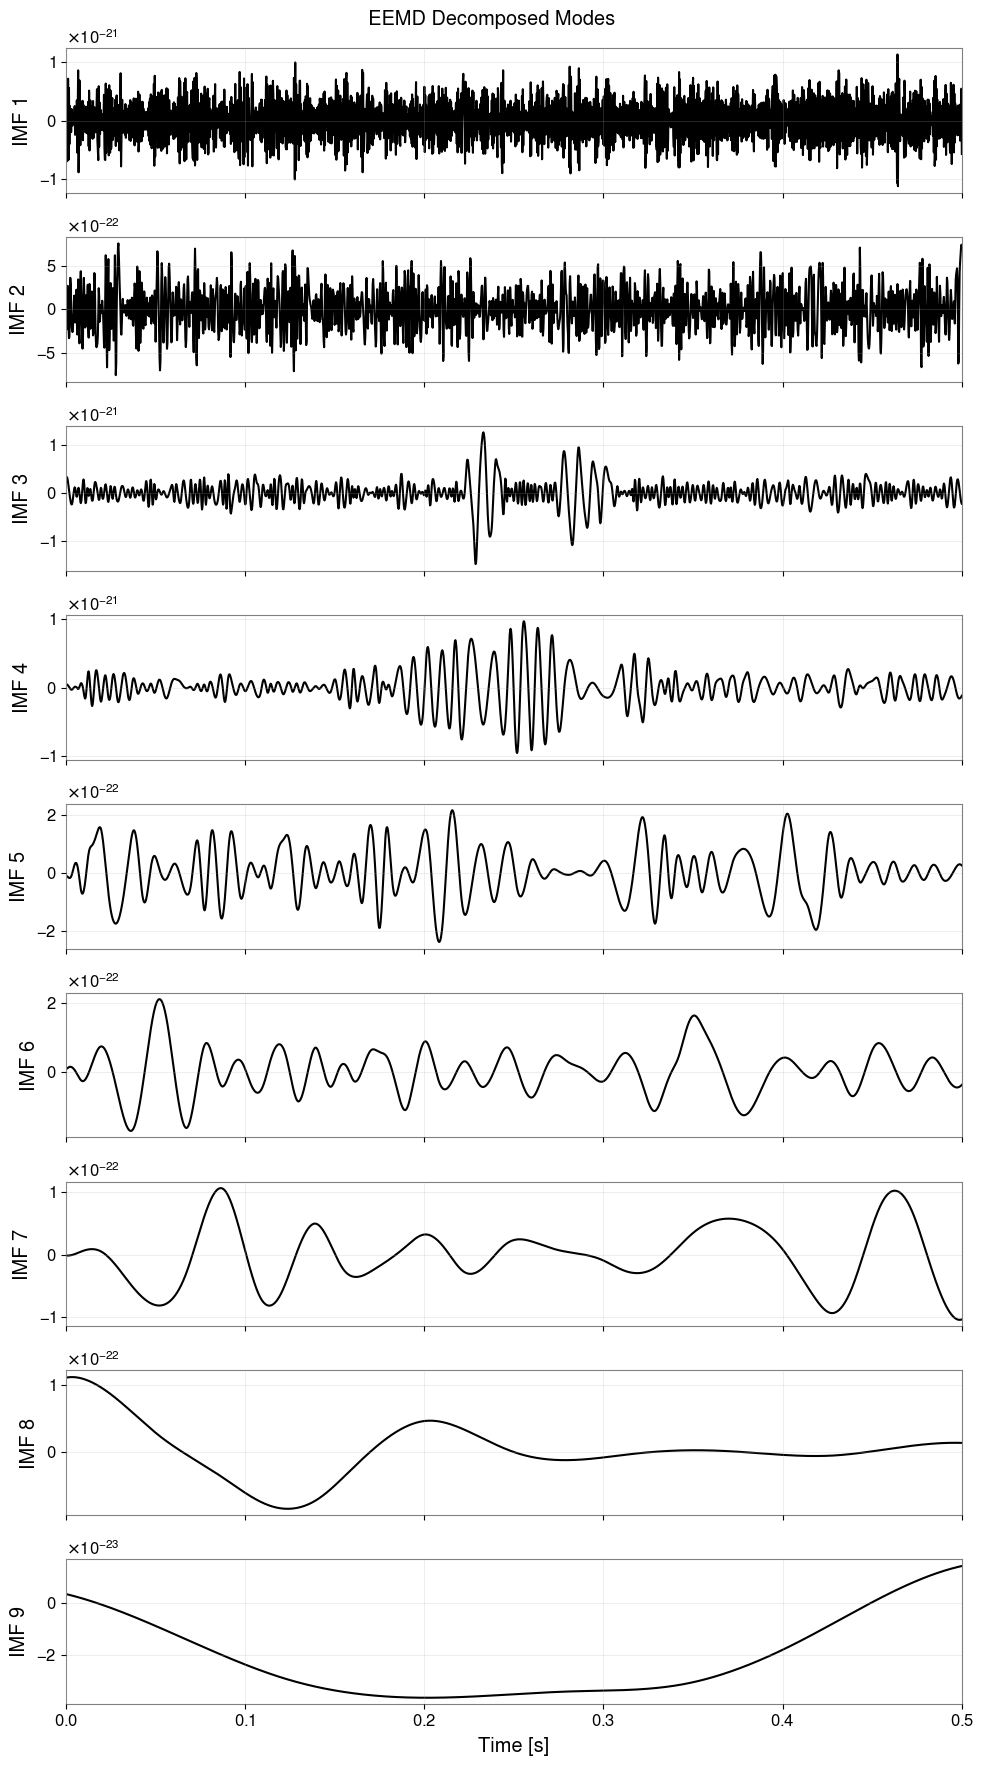

In [16]:
# EEMDの実行
from PyEMD import EEMD

# EEMDでも同様に正規化が推奨されます
eemd = EEMD(trials=10, noise_width=0.2)

print("Running EEMD on normalized data...")
eimfs_norm = eemd.eemd(data_norm)
eimfs = eimfs_norm * data_std
n_eimfs = eimfs.shape[0]
print(f"EEMD completed. Extracted {n_eimfs} IMFs.")

# 全てのIMFの可視化
fig, axes = plt.subplots(n_eimfs, 1, figsize=(10, 2 * n_eimfs), sharex=True)
if n_eimfs == 1:
    axes = [axes]

for i in range(n_eimfs):
    axes[i].plot(t, eimfs[i], "k")
    axes[i].set_ylabel(f"IMF {i + 1}")
    axes[i].grid(alpha=0.3)
    if i == n_eimfs - 1:
        axes[i].set_xlabel("Time [s]")
        axes[i].set_xlim(0, duration)

plt.suptitle("EEMD Decomposed Modes")
plt.tight_layout()
plt.show()